# Automated Essay Scoring
Automated scoring of social study evaluation

### Project Repo 
https://github.com/Testbild/azubi_evaluation_ml_with_tf

## Participants:
Name / Github User  

Christopher Hansen / Testbild  
Sabrina Ludwig / saludwig26  
Kerstin Eilers / kemeni23  
Christian Mayer / maychr

### Course and Semester
Machine Learning With Tensorflow / SoSe2021

### License
If you are releasing the software under some certain license, you can mention it and also include the `LICENSE.md` file in the folder

---

In [1]:
# Here you can start your code! Thanks

In [2]:
!pip install tensorflow-text

     |████████████████████████████████| 4.3MB 7.9MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import csv
import os
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras import regularizers
import tensorflow.keras.utils as ku
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors


import nltk 
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize 

import tensorflow as tf
import random

import tensorflow_text as text 

In [4]:
#In case of Google Colab run this:
from google.colab import files
uploaded = files.upload()

Saving data_MailsAndPC.csv to data_MailsAndPC.csv


In [5]:
import io
azubi_df = pd.read_csv(io.BytesIO(uploaded['data_MailsAndPC.csv']))

In [6]:
#Global Hyperparameters
vocab_size = 3000
embedding_dim = 32
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [7]:
#In case of local github export run this:
#DATA_FOLDER = './../data'
#AZUBI_DATA = 'data_MailsAndPC.csv'
#AZUBI_DATA_CLEANED = 'data_MailsAndPC_cleaned.csv'
#azubi_df = pd.read_csv(os.path.join(DATA_FOLDER, AZUBI_DATA))

# Data Preparation


## Data Preparation Functions

Selects the mail and item of interest from the azubi dataframe.  

Returns the dataframe only containing the columns of interest.

In [8]:
def selectColumns(azubi_df, mail, item):

  azubi_df_selected_columns = azubi_df[[mail,item]]

  return azubi_df_selected_columns

The dataframe needs to be cleaned from NaN values, as well as error codes in the labels. Furthermore linebreaks are indicated with the letters "cr". They have to be removed as well. The mails are in German language and we could not think of a German word that contains "cr", hence we think it is fine to just remove the "cr" and replace it with a space.  

Returns the cleaned azubi dataframe.

Expects the dataframe, the mail of interest, as well as the item of interest.

In [9]:
def cleanupDataframe(azubi_df, mail, item):
    #Remove unneccesary columns
    #azubi_df = azubi_df.drop(columns=['Unnamed: 0', 'id'])
    #Remove "cr". Assumption made, that there are no real words containing cr in the mails.
    azubi_df["S1_mail"] = azubi_df["S1_mail"].str.replace("cr", " ")
    azubi_df["S2_mail"] = azubi_df["S2_mail"].str.replace("cr", " ")
    azubi_df["S3_mail"] = azubi_df["S3_mail"].str.replace("cr", " ")
    
    azubi_df = selectColumns(azubi_df, mail, item)
    #Drop NA rows to only have full datasets
    azubi_df = azubi_df.dropna()
    #Select all rows without '99' | ~ inverts the operator
    dropThisNumber = 99
    azubi_df = azubi_df[~azubi_df.eq(dropThisNumber).any(1)]
    #Select all rows without '6' | ~ inverts the operator
    #dropThisNumber = 6
    #azubi_df = azubi_df[~azubi_df.eq(dropThisNumber).any(1)]
    #Reset the index of the Dataframe
    azubi_df = azubi_df.reset_index(drop=True)
    return azubi_df

The data needs to be split into Train/Dev/Test sets. We use the sklearn train_test_split function and manually divide the dev set into two subsets. Since the classes are not evenly split we also use stratification to make sure the sets contain equal numbers of each class.

Returns the X and Y for train, dev and test set.

Expects the X and Y that should be split, the test size (float between 0 and 1), a random seed and if stratification should be done.

In [10]:
def trainDevTestSplit_sklearn(X, Y, testSize, randomSeed, stratify):
  #Splits by test size into Train / Dev
  #Splits dev then 50/50 into dev and Test

  if (stratify == True):
    xTrain, xDev, yTrain, yDev = train_test_split(X, Y, test_size=testSize,stratify = Y, random_state=randomSeed)
  else:
    xTrain, xDev, yTrain, yDev = train_test_split(X, Y, test_size=testSize, random_state=randomSeed)

  xTest = xDev[:len(xDev)//2]
  yTest = yDev[:len(yDev)//2]
  
  xDev = xDev[len(xDev)//2:]
  yDev = yDev[len(yDev)//2:]
  #xDev, yDev, xTest, yTest = train_test_split(xDev, yDev, test_size =0.5, random_state = randomSeed)

  return xTrain, yTrain, xDev, yDev, xTest, yTest

In [11]:
def tokenizeData(vocab_size, oov_tok, train_sentences, max_length, padding_type, trunc_type):
    tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(train_sentences)
   
    word_index = tokenizer.word_index
    vocab_size=len(word_index)

    print("Word Index: \n")
    print(word_index)
    
    sequences = tokenizer.texts_to_sequences(train_sentences)

    print("Sequences: \n")
    print(sequences)
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

    return padded

The classes are categorical, like schoolgrades and have to be treated as such. In order to make the labels categorical we use One Hot Encoding. Keras provides the function to_categorical, which is used here. Since the Keras function checks the highest integer and makes as many columns as this number we have to remove the columns that are all zero. (E.g. your classes are 1,2 and 9 then to_categorical will make 9 columns, where 6 of them are always zero).

Returns one hot encoded labels.

Expects the labels to encode and if the zero columns should be removed (bool).

In [12]:
def oneHotEncodePreSplit(yTrain, removeZeros):
  #a = np.array([1, 0, 3])
  #yTrain = yTrain.astype(int)
  
  print("Unique Values:")
  print(np.unique(yTrain))
  print("\n")
  yTrainOneHot = tf.keras.utils.to_categorical(yTrain)
  print("Classes before removing zeros:")
  print(yTrainOneHot)
  print(yTrainOneHot.sum(axis=0))
  print("\n")

  if (removeZeros == True):
    yTrainOneHot = yTrainOneHot[:,~np.all(yTrainOneHot == 0, axis = 0)]
  print("Classes after removing zeros:")
  print(yTrainOneHot)
  print(yTrainOneHot.sum(axis=0))
  print("\n")

  return yTrainOneHot

Some functions and models require the data to be in a list (instead of array or dataframe). This function does this.

Returns two lists. A list with the mail sentences and a list with the scores.

Expects the azubi dataframe, the mail of interest and the score of interest.

In [13]:
def makeListSelectedColumns(azubi_df, mail, score):
  #Sentence S1
  mailSentences = azubi_df[mail].tolist()
  #Labels S1
  scoreLabels = azubi_df[score].tolist()

  return mailSentences, scoreLabels

## Stop Words


Some words have very little influence on the meaning of the sentence. Those words are stopwords and are usually removed. There are preset stopwords lists which we also took. 

In [14]:
#stopwords
def removeStopWordsSelectedColumns(azubi_df_cleaned, mail):

  nltk.download('punkt')
  nltk.download('stopwords')

  stemmer = SnowballStemmer("german")
  stop_words = set(stopwords.words("german"))
  #stop_words.add('Meier')
  #stop_words.add('Neumann')

  azubi_df_cleaned_no_stopwords = pd.DataFrame()

  pat = r'\b(?:{})\b'.format('|'.join(stop_words))
  azubi_df_cleaned[mail] = azubi_df_cleaned[mail].str.replace(pat, '')
  azubi_df_cleaned[mail] = azubi_df_cleaned[mail].str.replace(r'\s+', ' ')

  return azubi_df_cleaned



## Show Model Performance

Comfort function for easier plotting of the graphs

In [15]:
def showModelPerformance(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title('Random Forest Model')
    plt.legend([string, 'val_'+string])
    plt.show()

    return

## Combine all mails for a4s2_combined_i2b score

The score a4s1i2b, a4s2i2b and a4s3i2b describes the politeness of the mail. This score is unrelated to the topic of the mail. Hence to have more training data available all mails have been combined to train this score.

In [16]:
#Create new dataframe
azubi_df_mails_and_scored_combined = pd.DataFrame(columns=["Mails_Combined", "a4s_combined_i2b"])
#Use cleanup function to select the correct data from the dataframe
azubi_df_mail1 = cleanupDataframe(azubi_df, 'S1_mail', 'a4s1i2b')
azubi_df_mail2 = cleanupDataframe(azubi_df, 'S2_mail', 'a4s2i2b')
azubi_df_mail3 = cleanupDataframe(azubi_df, 'S3_mail', 'a4s3i2b')

In [17]:
#Rename the columns
azubi_df_mail1_renamed = azubi_df_mail1.rename(columns={"S1_mail": "Mails_Combined", "a4s1i2b": "a4s_combined_i2b"})
azubi_df_mail2_renamed = azubi_df_mail2.rename(columns={"S2_mail": "Mails_Combined", "a4s2i2b": "a4s_combined_i2b"})
azubi_df_mail3_renamed = azubi_df_mail3.rename(columns={"S3_mail": "Mails_Combined", "a4s3i2b": "a4s_combined_i2b"})

In [18]:
#Append the renamed columns, ignore index so it is appended at the end
azubi_df_mails_and_scored_combined = azubi_df_mails_and_scored_combined.append(azubi_df_mail1_renamed, ignore_index=True)
azubi_df_mails_and_scored_combined = azubi_df_mails_and_scored_combined.append(azubi_df_mail2_renamed, ignore_index=True)
azubi_df_mails_and_scored_combined = azubi_df_mails_and_scored_combined.append(azubi_df_mail3_renamed, ignore_index=True)

In [19]:
azubi_df_mails_and_scored_combined = azubi_df_mails_and_scored_combined[azubi_df_mails_and_scored_combined.a4s_combined_i2b != 9.0]
azubi_df_mails_and_scored_combined = azubi_df_mails_and_scored_combined[azubi_df_mails_and_scored_combined.a4s_combined_i2b != 2.0]
azubi_df_mails_and_scored_combined = azubi_df_mails_and_scored_combined.reset_index()

In [ ]:
azubi_df_mails_and_scored_combined['Mails_Combined'][2]

In [21]:
azubi_df_mails_and_scored_combined['a4s_combined_i2b']

0       1.0
1       1.0
2       0.0
3       1.0
4       1.0
       ... 
2082    0.0
2083    1.0
2084    1.0
2085    1.0
2086    1.0
Name: a4s_combined_i2b, Length: 2087, dtype: float64

In [ ]:
azubi_df_mails_and_scored_combined

### Selected Columns Scores

This function returns the Train, Dev and Test sets, as well as the cleaned azubi_df. The Train, Dev and Test sets (including labels) are in a format, that can be read by the models afterwards.

In [23]:
def prepareDataSelectedColumns(azubi_df, mail, score, doCleanup, paddedOutput, word2vec): 
  #Prepare the data
  if doCleanup == True:
    azubi_df_cleaned = cleanupDataframe(azubi_df, mail, score)
  else:
    azubi_df_cleaned = azubi_df
  #print(azubi_df_cleaned[score][9])

  #Remove Stop words
  #azubi_df_cleaned_no_stopwords = removeStopWordsSelectedColumns(azubi_df_cleaned, mail)
  mailSentences, scoreLabels = makeListSelectedColumns(azubi_df_cleaned, mail, score)
  print(len(mailSentences))
  print(len(scoreLabels))

  yTrainOneHot = oneHotEncodePreSplit(np.array(scoreLabels), True)

  if paddedOutput == True and word2vec == False:
    print("Padded Output True")
    padded = tokenizeData(vocab_size, oov_tok, mailSentences, max_length, padding_type, trunc_type)
    xTrain, yTrain, xVal, yVal, xTest, yTest = trainDevTestSplit_sklearn(padded, yTrainOneHot, 0.1, 42, False)
  elif word2vec == True and paddedOutput == False:
    padded = word2vecTokenizer(mailSentences, glove_vectors)
    print(padded)
  else:
    xTrain, yTrain, xVal, yVal, xTest, yTest = trainDevTestSplit_sklearn(mailSentences, yTrainOneHot, 0.4, 42, False)

  xTrainArray = xTrain#np.array(xTrain)
  yTrainArray = yTrain#np.array(yTrain)


  xValArray = xVal#np.array(xVal)
  yValArray = yVal#np.array(yVal)


  xTestArray = xTest#np.array(xTest)
  yTestArray = yTest#np.array(yTest)
  print(len(xTrainArray))
  print(len(yTrainArray))
  print(len(xValArray))
  print(len(yValArray))
  print(len(xTestArray))
  print(len(yTestArray))


  return xTrainArray, yTrainArray, xValArray, yValArray, xTestArray, yTestArray, azubi_df_cleaned


In [24]:
#xTrainArray

In [25]:
xTrainArray, yTrainArray, xValArray, yValArray, xTestArray, yTestArray, azubi_df_cleaned_no_stopwords = prepareDataSelectedColumns(azubi_df_mails_and_scored_combined, 'Mails_Combined', 'a4s_combined_i2b', False, False, False)

2087
2087
Unique Values:
[0. 1.]


Classes before removing zeros:
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[ 146. 1941.]


Classes after removing zeros:
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[ 146. 1941.]


1252
1252
418
418
417
417


In [26]:
xTrainArray2, yTrainArray2, xValArray2, yValArray2, xTestArray2, yTestArray2, azubi_df_cleaned_no_stopwords2 = prepareDataSelectedColumns(azubi_df, 'S2_mail', 'a4s2i2b', True,  False, False)

725
725
Unique Values:
[0. 1. 2. 9.]


Classes before removing zeros:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[ 38. 666.   1.   0.   0.   0.   0.   0.   0.  20.]


Classes after removing zeros:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
[ 38. 666.   1.  20.]


435
435
145
145
145
145


In [ ]:
xTrainArray3, yTrainArray3, xValArray3, yValArray3, xTestArray3, yTestArray3, azubi_df_cleaned_no_stopwords3 = prepareDataSelectedColumns(azubi_df_mails_and_scored_combined, 'Mails_Combined', 'a4s_combined_i2b', False, True, False)

In [28]:
xTrainArray4, yTrainArray4, xValArray4, yValArray4, xTestArray4, yTestArray4, azubi_df_cleaned_no_stopwords4 = prepareDataSelectedColumns(azubi_df_mails_and_scored_combined, 'Mails_Combined', 'a4s_combined_i2b', False, False, False)

2087
2087
Unique Values:
[0. 1.]


Classes before removing zeros:
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[ 146. 1941.]


Classes after removing zeros:
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[ 146. 1941.]


1252
1252
418
418
417
417


# Primitive Models

## SVM

Function for a Support Vector Machine with the SGDClassifier (stochastic gradient descent) from the sklearn library.

Important hyperparameters: The regularization term "penalty" adds a penalty to the loss function using the squared euclidean norm L2 by default. "alpha" is a constant by which the regularization term is multiplied; the higher the value, the stronger the regularization; 0.0001 is set by default, but with 0.01 we had the best results. "max_iter" is the maximum number of epochs. Finally, "class_weight" assigns weights to each class; class_weight = "balance" uses the values of the labels to automatically adjust weights inversely proportional to class frequencies. This mode achieved the best results.

Funtion returns the model and the prediction of the class labels, and prints the accuracy of the model and the classification report for the two classes. 




In [29]:
## Linear Support Vector Machine
def svmModel(X_train, y_train, X_test, y_test):
  sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=0.01, random_state=42, max_iter=5, tol=None, shuffle=True, class_weight="balanced")), # class_weight={0: 10} 
               ])
  sgd.fit(X_train, y_train)

  #%%time
  
  y_pred = sgd.predict(X_test)
  my_tags = ['class 0', 'class 1']

  print('accuracy %s' % accuracy_score(y_pred, y_test))
  print(classification_report(y_test, y_pred,target_names=my_tags))
  return sgd, y_pred

##Logistic Regression

Function for a logistic regression algorithm. 

Important hyperparameters: "C" inverses regularization strength; the default value is 1.0. The remaining parameters have already been described for the svm model.

Function returns the model and the prediction of the class labels, and prints the accuracy of the model and the classification report for the two classes.

In [30]:
def lgModel(X_train, y_train, X_test, y_test):
  logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=5, C=5.0, class_weight="balanced")), #C=1e5, C=1e-1 #class_weight="balanced", class_weight={0: 50}
               ])
  logreg.fit(X_train, y_train)

  #%%time

  y_pred = logreg.predict(X_test)
  y_predProba = logreg.predict_proba(X_test)
  my_tags = ['class 0', 'class 1']
  print('accuracy %s' % accuracy_score(y_pred, y_test))
  print(classification_report(y_test, y_pred,target_names=my_tags))
  return logreg, y_pred, y_predProba

## Random Forest

Function for a Random Forest Classifier. 

Important hyperparameters: The default value for "n_estimators" (number of trees in the forest) is 100. A much higher or much lower number of trees produced worse results. Unlike the two previous models, when adding the "class_weight" parameter, the f1 score for the underrepresented class got much worse.
 
Function returns the model and the prediction of the class labels, and prints the accuracy of the model and the classification report for the two classes.

In [31]:
def randomtree_Model(n_estimators, X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(n_estimators = n_estimators, criterion  = 'entropy', random_state = 42) #class_weight="balanced") 

    history = model.fit(X_train, y_train)

    y_predict = model.predict(X_test)

    print(confusion_matrix(y_test,y_predict))
    print(classification_report(y_test,y_predict))
    print(accuracy_score(y_test, y_predict))
    return model, history, y_predict

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

try:
    get_ipython().magic('matplotlib inline')
    get_ipython().magic('config InlineBackend.figure_formats = set(["retina"])')
except NameError:
    pass

def plot_classifier(model, X_test, y_test, proba=True, xlabel='Essays', ylabel='Politeness'):
    # https://matplotlib.org/examples/color/colormaps_reference.html
    plt.set_cmap("RdYlBu")
    
    x_min = X_test[:, 0].min() - 1
    x_max = X_test[:, 0].max() + 1
    
    y_min = X_test[:, 1].min() - 1
    y_max = X_test[:, 1].max() + 1
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 1000),
        np.linspace(y_min, y_max, 1000)
    )

    if proba:
        zz = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        plt.imshow(zz.reshape(xx.shape), 
                   origin = "lower", 
                   aspect = "auto", 
                   extent = (x_min, x_max, y_min, y_max), 
                   vmin = 0, 
                   vmax = 1, 
                   alpha = 0.25)
    else: 
        zz = model.predict(np.c_[xx.ravel(), yy.ravel()])
        plt.contourf(xx, yy, zz.reshape(xx.shape), 
                     alpha = 0.25, 
                     vmin = 0, 
                     vmax = 1)

    plt.scatter(X[:, 0], X[:, 1], c=Z)
    
    if xlabel is not None:
        plt.xlabel(xlabel)
       
    if ylabel is not None:
        plt.ylabel(ylabel)
        
    # Damit wird die Grafik genau so groß angezeigt wie der
    # schattierte Farbbereich:
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.show()

In [33]:
#Rt_plot = plot_classifier(modelRandomForest, xValArray, yValArray[:,1], proba=True, xlabel='Essays', ylabel='Politeness')

# Execute Primitive Models

The functions defined above for the primitive models are executed.


The randomtree_Model function receives as input the number of trees and the untokenized training and test datasets. 

In [ ]:
xTrainArray3, yTrainArray3, xValArray3, yValArray3, xTestArray3, yTestArray3, azubi_df_cleaned_no_stopwords3 = prepareDataSelectedColumns(azubi_df_mails_and_scored_combined, 'Mails_Combined', 'a4s_combined_i2b', False, True, False)

In [109]:
xValTestArray3 = np.concatenate((xValArray3, xTestArray3))
yValTestArray3 = np.concatenate((yValArray3, yTestArray3))

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
xTrainArray3_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(xTrainArray3)
xTrainArray3_embedded = TSNE(n_components=2).fit_transform(xTrainArray3_reduced)
xValTestArray3_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(xValTestArray3)
xValTestArray3_embedded = TSNE(n_components=2).fit_transform(xValTestArray3_reduced)

In [110]:
#Execute random forest model
modelRandomForest,historyRandomForest, y_predictRandomForest = randomtree_Model(100, xTrainArray3_embedded, yTrainArray3[:,1], xValTestArray3_embedded, yValTestArray3[:,1])

[[  0  11]
 [  1 197]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.95      0.99      0.97       198

    accuracy                           0.94       209
   macro avg       0.47      0.50      0.49       209
weighted avg       0.90      0.94      0.92       209

0.9425837320574163


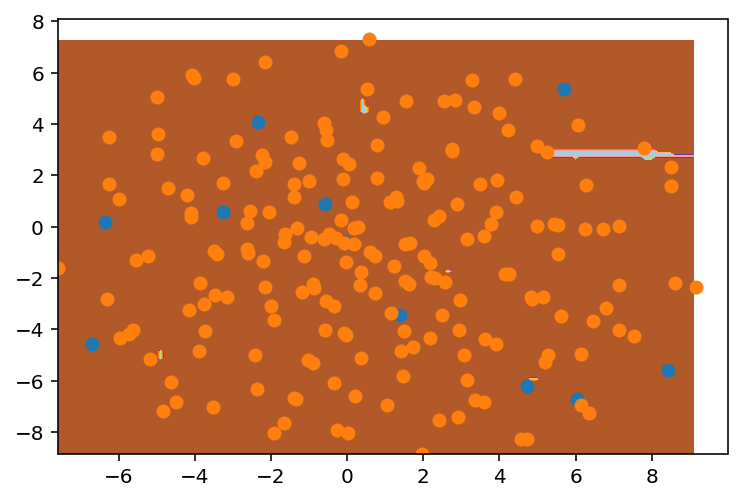

In [117]:
# define bounds of the domain
xmin, xmax = np.min(xValTestArray3_embedded[:,0]), np.max(xValTestArray3_embedded[:,0])
ymin, ymax = np.min(xValTestArray3_embedded[:,1]), np.max(xValTestArray3_embedded[:,1])
# define the x and y scale
xgrid = np.arange(xmin, xmax, 0.1)
ygrid = np.arange(ymin, ymax, 0.1)
# create all of the lines and rows of the grid
xx, yy = np.meshgrid(xgrid, ygrid)
# flatten each grid to a vector
rx, ry = xx.flatten(), yy.flatten()
#r = np.array(r)
rx, ry = rx.reshape((len(rx), 1)), ry.reshape((len(ry), 1))
# horizontal stack vectors to create x input for the model
grid = np.hstack((rx, ry))
# make predictions for the grid
y_predLggrid = modelRandomForest.predict(grid)
# reshape the predictions back into a grid
zz = y_predLggrid.reshape(xx.shape)
# plot the grid of x, y and z values as a surface
pyplot.contourf(xx, yy, zz, cmap='Paired')
# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(yValTestArray3[:,1] == class_value)
    # create scatter of these samples
    plt.scatter(xValTestArray3_embedded[row_ix, 0], xValTestArray3_embedded[row_ix, 1], cmap='Paired')

The lgModel function receives as input the untokenized training and test datasets. 

In [35]:
#Execute logistic regression Model
logreg, y_predLg, y_predProbaLg = lgModel(xTrainArray4, yTrainArray4[:,1], xValArray4, yValArray4[:,1])

accuracy 0.9425837320574163
              precision    recall  f1-score   support

     class 0       0.74      0.42      0.54        33
     class 1       0.95      0.99      0.97       385

    accuracy                           0.94       418
   macro avg       0.84      0.71      0.75       418
weighted avg       0.94      0.94      0.94       418



The svmModel function receives as input the untokenized training and test datasets. 

In [36]:
#Execute svmModel
sgd, y_predSgd = svmModel(xTrainArray4, yTrainArray4[:,1], xValArray4, yValArray4[:,1])

accuracy 0.9282296650717703
              precision    recall  f1-score   support

     class 0       0.55      0.48      0.52        33
     class 1       0.96      0.97      0.96       385

    accuracy                           0.93       418
   macro avg       0.75      0.73      0.74       418
weighted avg       0.92      0.93      0.93       418



# Word2Vec

## preparation

Sources and tutorials i used to create word2vec embeddings:


In [37]:
#Word2vec approach. We followed a mix out of several turoials:
#    https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html
#    https://discuss.huggingface.co/t/generate-raw-word-embeddings-using-transformer-models-like-bert-for-downstream-process/2958
#    https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
#    https://phdstatsphys.wordpress.com/2018/12/27/word2vec-how-to-train-and-update-it/

Import, especially gensim and gensim.downloader for word2vec if you like to use a pretrained word2vec

In [38]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
# for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
!pip install lime
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
#!pip install transformer
#from transformer

     |████████████████████████████████| 276kB 8.8MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283858 sha256=fe35bcb4d56653a06f22a3144f1c622b5ad922912e51da7eafccbee0656d085f
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


Take a look into the dataframe to ensure everything is okay

In [ ]:
azubi_df_mails_and_scored_combined

In [ ]:
azubi_df_mails_and_scored_combined.sample(5)

And now we remove stopwords

In [41]:
azubi_df_mails_and_scored_combined = removeStopWordsSelectedColumns(azubi_df_mails_and_scored_combined,'Mails_Combined')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


and take a look into the cleaned dataframe again

In [ ]:
azubi_df_mails_and_scored_combined

In [ ]:
azubi_df_mails_and_scored_combined.sample(5)

We want to make sure our data set is balanced. Which is not the case. Thus, we include weights lateron in the model. Here you can see the inbalance for this variable clearly.

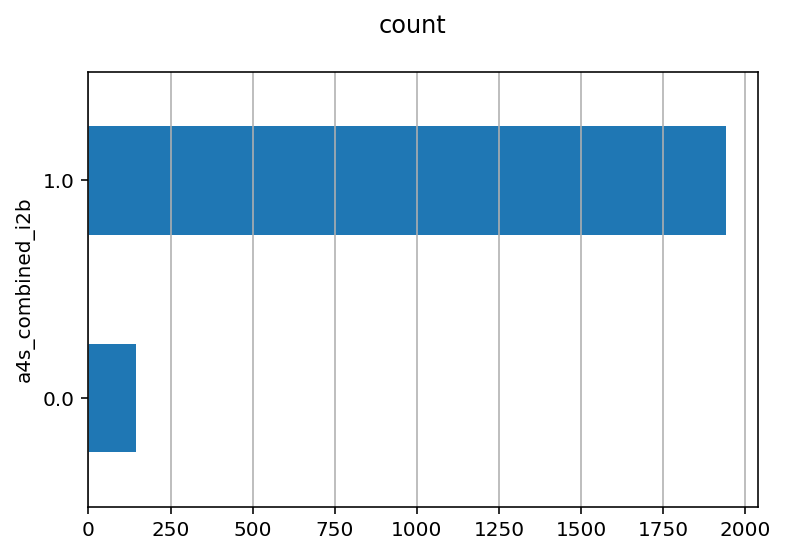

In [44]:
fig, ax = plt.subplots()
fig.suptitle("count", fontsize=12)
azubi_df_mails_and_scored_combined["a4s_combined_i2b"].reset_index().groupby("a4s_combined_i2b").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

Lets split the data into a train and test set.

In [45]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(azubi_df_cleaned_no_stopwords, test_size=0.3)## get target
y_train = dtf_train["a4s_combined_i2b"].values
y_test = dtf_test["a4s_combined_i2b"].values

## word2vec

Here we start with the word2vec after our data preprocessing. Download a already pretrained word2vc might take some time... if you like here are some facts about word2vec: 

*The word2vec tool takes a text corpus as input and produces the word vectors as output. It first constructs a vocabulary from the training text data and then learns vector representation of words. The resulting word vector file can be used as features in many natural language processing and machine learning applications.*

(more info: https://code.google.com/archive/p/word2vec/)

In [46]:
# download word2vec takes 10 min
#we could use this word2vec pretrained model by using this line of code, but instead we wanted to make a word2vec embedding with our own corpus, because word2vec wasn't trained with business mails
# nlp = gensim_api.load("word2vec-google-news-300") 

Lets use word2vec with our dataframe and create our own embeddings. We define unigrams  to determine intersting (rather polite or inpolite) word vectors. The functions we use are part of gensim, so this is also super easy.

In [47]:
corpus =  dtf_train["Mails_Combined"]
## create list of lists of unigrams (#Sehr)
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)
## detect bigrams (#Sehr geehrter) and trigrams (#Sehr geehrte:r Herr:Frau)
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)



This part is crucial. We determine the setup to create our word embeddings.
- target size = size of the word vectors
- window =  the maximum distance between a current and predicted word within a mail
- sg = training algorithm. skip-grams (sg=1) is used as it was used in the tutorial and this should also in general lead to the best results in most cases
- iter = number of iterations (10, 20, 30)

In [48]:
#word2vec setup
#play with size=300, window = 8? mean lenght?
# target size, mean length window of distance, and sgram 1: has proven robust 
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=5, min_count=3, sg=1, iter=30)



How is our vector shaped? It is a 1dim array. Lets take a closer look:

In [49]:
word = "freundlichen"
nlp[word].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(300,)

This is the vector for [word]. Cool Hmm? Test it for yourself if you like to play with...

In [50]:
nlp[word]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-2.50112474e-01, -3.40942055e-01,  5.51413037e-02, -5.63187245e-03,
       -5.83968721e-02,  9.69432816e-02, -7.28698969e-02,  5.48280716e-01,
       -2.13935971e-01,  4.36667055e-01,  5.71018934e-01, -2.51483470e-01,
        7.79870078e-02, -4.41263110e-04, -2.19256461e-01,  7.52539467e-03,
        1.46278486e-01, -6.69267476e-02, -5.46562597e-02, -2.69921809e-01,
       -3.40576261e-01, -6.96190223e-02,  1.29722223e-01,  6.19680583e-02,
        2.18405873e-01,  1.55147716e-01,  8.54398968e-05,  2.94900630e-02,
       -2.19748974e-01,  7.26971105e-02, -2.39120141e-01, -1.86621204e-01,
        3.08016874e-02, -2.72204041e-01, -4.62095767e-01,  2.23840609e-01,
       -1.33864522e-01, -2.26122811e-01,  2.07978219e-01, -2.91371811e-03,
        5.57583272e-02,  9.12566856e-02,  5.77398092e-02, -6.54490888e-02,
       -3.39094132e-01, -1.94695871e-02,  1.26971453e-01, -7.49199763e-02,
        9.25984830e-02, -3.63573879e-01,  3.93963546e-01,  1.47267044e-01,
        1.49964660e-01,  

We can print this also in a *3d* space with related words...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


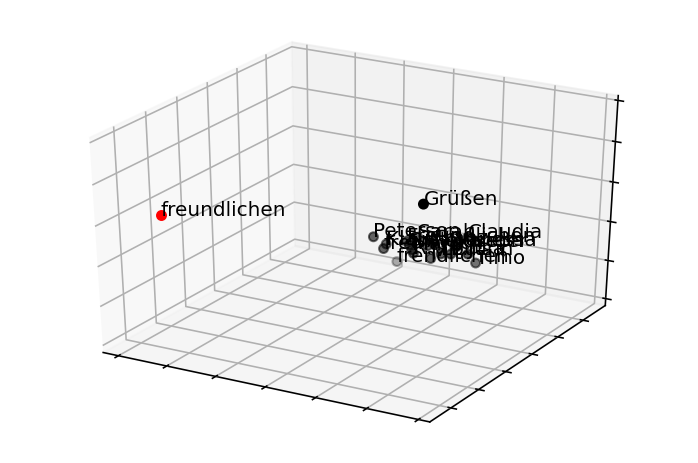

In [51]:
word = word
fig = plt.figure()## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

*note: maybe we can add here a download buttom to upload these files in this cool tensorflow showcase for word embeddings
shortcoming: need to be lowercased, thus might not be appropriate to measure politeness in german, e.g. Sie vs. sie / Ihre vs ihre*

Ok, lets use our embeddings by tokenizing, sequencing and padding our mails.


In [52]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=False, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=150, padding="post", truncating="post") #need to think about maxlen

How does our features look like? We see here a feature map where we see that some mails contains more features (black) than others.

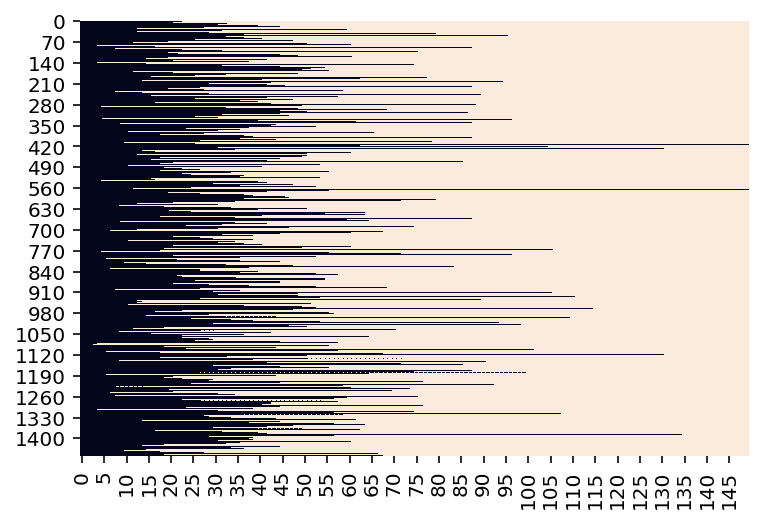

In [53]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()
#feature matrixy visual x * 120

Lets see if this worked... you can again change the i value to whatever u like

In [54]:
i = 10

# list of text: ["I like this", ...]
len_txt = len(dtf_train["Mails_Combined"].iloc[i].split())
print("from: ", dtf_train["Mails_Combined"].iloc[i], "| len:", len_txt)

# sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

# vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", dtf_train["Mails_Combined"].iloc[i].split()[0], 
      " -- idx in vocabulary -->",  
      dic_vocabulary[dtf_train["Mails_Combined"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:10]), "... (padding element, 0)")

from:  Hallo Herr Neumann, Make-or-Buy-Analyse durchgeführt Schluss gekommen, Fremdbezug vormontierten Teile deutlich günstiger . Leider konnte enthaltenen variablen Anteil Gemeinkostenzuschlägssätzen anfangen deswegen normalen Zuschlagssätzen, Dokument firmeninternen Netzwerk Klammern standen, gerechnet. Allerdings darf Preis berücksichtigt . Wichtig , Made Germany momentan gefragt . Eigenfertigung Qualität Deutschland sprechen gutes Image Öffentlichkeit sorgen. Weiterhin Fremdbezug Zulieferer abhängig, Lieferschwierigkeiten ganze Produktionsprozess Erliegen kommen . Wir immer Arbeitsbedingungen Ort Produktqualität Klaren Imageverlusten führen. Außerdem firmeninternes Know-How verloren gehen. Der Preisvorteil bzw. Kostenvorteil nciht Hand weisen. Deswegen dafür aussprechen, Fremdbezug vormontierten Teile Probe durchzuführen hinterher analysieren, geklappt . Mit freundlichen Grüßen Britta Baumann | len: 96
to:  [   3    4    5 4510  922  923  112   42 1476  142  103   81    2   49
   2

We need to "engineer" the same features on the test set too!

In [55]:
### do some engineering
corpus = dtf_test["Mails_Combined"]
## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    ## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, 
                                            maxlen=150,
             padding="post", truncating="post")

And now we create the matrix of embeddings that will be used as a weight matrix in the neural network classifier.

In [56]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))

for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


Just a final check to see if everything is all right

In [57]:
word = "freundlichen"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 9 |idx
embeddings[idx]: (300,) |vector


Lets quickly measure the inbalance to get some class_weights

In [58]:
# we need to fix our inbalanced dataset by using a balance function by sklearn
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([7.3       , 0.53676471])

And now we define our model without an attention but an embedding layer. We use an embedding layer to include our embeddings as untrainable weights, and a small RNN with two bidirectional LSTM layers, a dense layer and an output layer with 2 neurons, and a softmax as activation function. (we use this model design, as it was sucessfully used in a similar task).

In [59]:
from tensorflow import keras

## input
x_in = layers.Input(shape=(150,))## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=150, trainable=False)(x_in)
## apply attention
#x = attention_layer(x, neurons=150)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=200, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=200, dropout=0.2,
                          return_sequences=False))(x)
#x = layers.LSTM(units=100, dropout=0.2)(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(2, activation='softmax')(x)
#y_out = layers.Dense(1, activation='sigmoid')(x)## compile
model = models.Model(x_in, y_out)

opt = keras.optimizers.Adam(lr=1e-6)
model.compile(loss='sparse_categorical_crossentropy',  # #binary_crossentropy 
              optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 300)          3478800   
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 400)          801600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 400)               961600    
_________________________________________________________________
dense (Dense)                (None, 64)                25664     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 5,267,794
Trainable params: 1,788,994
Non-trainable params: 3,478,800
___________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
19/19 - 10s - loss: 0.6660 - accuracy: 0.1070 - val_loss: 0.7211 - val_accuracy: 0.0788
Epoch 2/50
19/19 - 1s - loss: 0.6650 - accuracy: 0.1353 - val_loss: 0.7161 - val_accuracy: 0.1130
Epoch 3/50
19/19 - 1s - loss: 0.6638 - accuracy: 0.1618 - val_loss: 0.7125 - val_accuracy: 0.1473
Epoch 4/50
19/19 - 1s - loss: 0.6640 - accuracy: 0.2046 - val_loss: 0.7085 - val_accuracy: 0.1815
Epoch 5/50
19/19 - 1s - loss: 0.6628 - accuracy: 0.2517 - val_loss: 0.7041 - val_accuracy: 0.2671
Epoch 6/50
19/19 - 1s - loss: 0.6618 - accuracy: 0.3219 - val_loss: 0.6990 - val_accuracy: 0.3527
Epoch 7/50
19/19 - 1s - loss: 0.6610 - accuracy: 0.3733 - val_loss: 0.6960 - val_accuracy: 0.4247
Epoch 8/50
19/19 - 1s - loss: 0.6603 - accuracy: 0.4521 - val_loss: 0.6920 - val_accuracy: 0.5274
Epoch 9/50
19/19 - 1s - loss: 0.6589 - accuracy: 0.5051 - val_loss: 0.6885 - 

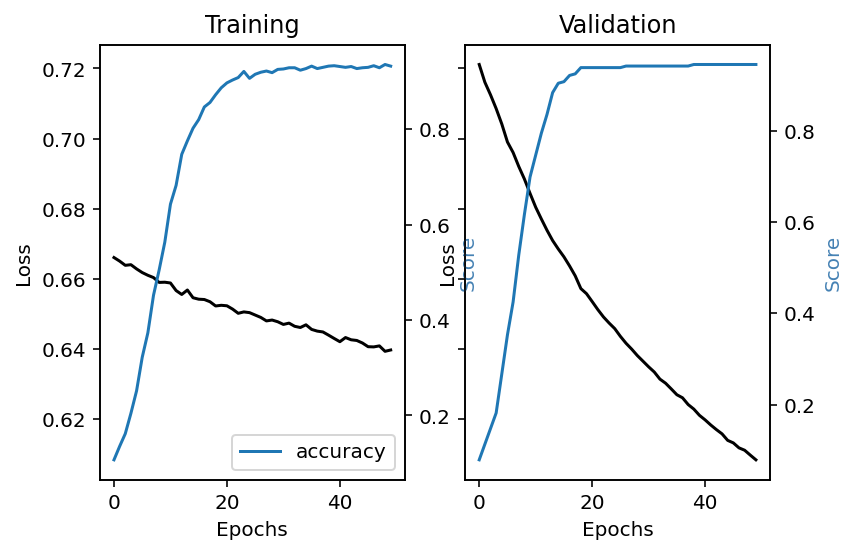

In [60]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

## train
training = model.fit(x=X_train, y=y_train, batch_size=64, 
                     epochs=50, shuffle=True, verbose=2, 
                     validation_split=0.2, class_weight={0:7, 1:0.5}) #0:14, 1:1

## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)

ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()

ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()



Lets see if this works

In [61]:
def showModelPerformance(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title('Model')
    plt.legend([string, 'val_'+string])
    plt.show()
    
    return

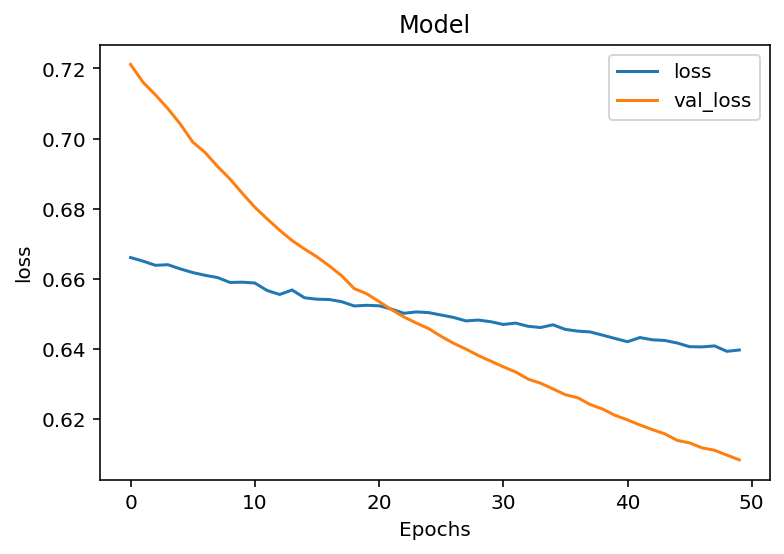

In [62]:
showModelPerformance(training, "loss")

In [63]:
predictions=model.predict(X_test)

In [64]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [65]:
predictions

array([[0.50005174, 0.49994826],
       [0.50216776, 0.49783227],
       [0.5050537 , 0.49494624],
       [0.4961651 , 0.50383496],
       [0.48354408, 0.51645595],
       [0.5042165 , 0.49578357],
       [0.49711767, 0.5028823 ],
       [0.4871724 , 0.51282763],
       [0.46852592, 0.53147405],
       [0.49216488, 0.5078351 ],
       [0.47436902, 0.525631  ],
       [0.45533434, 0.5446657 ],
       [0.48502004, 0.51497996],
       [0.49471164, 0.5052884 ],
       [0.45746717, 0.54253286],
       [0.49641573, 0.50358427],
       [0.48987877, 0.5101212 ],
       [0.48874232, 0.51125765],
       [0.5046701 , 0.49532992],
       [0.48340452, 0.5165955 ],
       [0.49702084, 0.50297916],
       [0.51235044, 0.48764956],
       [0.5011189 , 0.49888107],
       [0.48802057, 0.51197946],
       [0.4961994 , 0.50380063],
       [0.49895975, 0.5010403 ],
       [0.4842235 , 0.5157765 ],
       [0.48907962, 0.51092035],
       [0.5161777 , 0.4838223 ],
       [0.49766478, 0.5023352 ],
       [0.

In [66]:
predictionslabels = predictions.argmax(axis=1)


In [67]:
classes = predictionslabels-y_test

In [68]:
classes

array([ 0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1., -1.,  0.,  0.,  0.,
        0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,
        0.,  0., -1.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0.,  1.,
        0., -1.,  0.,  0.,  0., -1.,  0., -1.,  0.,  0., -1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  1.,
       -1.,  1.,  0.,  0., -1., -1.,  0.,  1.,  0.,  0.,  0., -1.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1., -1.,  1.,
       -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
        0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0

Several problems might be implemented in this approach:
- maybe our dataset is to small to create our own embeddings
- maybe we made some major fails when creating embeddings or the model
- its definitely overfitting ;-)

anyways... lets continue with a pretrained model (BERT)

# Transfer and self designed Models

## Fit learning rate


This learning rate tuner would allow for the self designed model to find a good initial learning rate. If you change the architecture of your model, you will also have to change it in the learning rate tuner.

In [69]:
def fitLearningRate(training_padded, training_labels,validation_padded, validation_label, vocab_size, embedding_dim, max_length, num_epochs):
  
  model = tf.keras.Sequential([
   
  tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')])
  
  #Fit the model
  #Input: compiled Model, Train and Validation Data, Batch Size and trainingEpochs
  #Return: history and model
  optimizer = tf.keras.optimizers.RMSprop(lr=1e-6)
  model.compile(optimizer = optimizer,
                loss='binary_crossentropy', metrics=['accuracy'])
  lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
  

  print("xtrain")
  print(training_padded.shape)
  print("ytrain")
  print(training_labels.shape)
  print("xval")
  print(validation_padded.shape)
  print("yval")
  print(validation_label.shape)
  

  # fit network
  history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_label),callbacks=[lr_schedule], verbose=2)

  # plot history
  plt.semilogx(history.history["lr"], history.history["loss"])
  plt.show()
  #pyplot.legend()
  #pyplot.show()
  #history = compiledModel.fit(xTrain, yTrain,batch_size=512, epochs = trainingEpochs,callbacks=[lr_schedule])

  return model, history

## Bidirectional Binary

First approach for a model to automatically score the essays. It was only of minor success and has not been continued after starting with transfer learning approaches.

In [70]:
def startermodelBidirectionalExperimentalBinary(training_padded, training_labels,validation_padded, validation_label, vocab_size, 
                                                embedding_dim, max_length, num_epochs): #weights=[embeddings_matrix], trainable=False

  model = tf.keras.Sequential([
   
    tf.keras.layers.Embedding(input_dim = vocab_size+1, output_dim = embedding_dim, input_length=max_length, mask_zero=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')])
  
  metric = tf.keras.metrics.BinaryAccuracy()
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.8)
  
  optimizerAdam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
  optimizerSGD = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

  model.compile(loss='binary_crossentropy',optimizer=optimizerAdam ,metrics=metric)
  model.summary()
  model.save_weights('model.h5')

  class_weights = {0: 1.,
                1: 0.1}

  # fit network
  history = model.fit(training_padded, training_labels, epochs=num_epochs,batch_size=32, validation_data=(validation_padded, validation_label), verbose=2)
  returnmodel = model
  model.load_weights('model.h5')
  # plot history
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()

  pyplot.plot(history.history['binary_accuracy'], label='train')
  pyplot.plot(history.history['val_binary_accuracy'], label='test')
  pyplot.legend()
  pyplot.show()
          
  return returnmodel, history

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


xtrain
(1878, 120)
ytrain
(1878,)
xval
(105, 120)
yval
(105,)
Epoch 1/100
59/59 - 2s - loss: 0.7042 - accuracy: 0.2082 - val_loss: 0.7067 - val_accuracy: 0.1238
Epoch 2/100
59/59 - 0s - loss: 0.7033 - accuracy: 0.2220 - val_loss: 0.7063 - val_accuracy: 0.1238
Epoch 3/100
59/59 - 0s - loss: 0.7030 - accuracy: 0.2258 - val_loss: 0.7057 - val_accuracy: 0.1238
Epoch 4/100
59/59 - 0s - loss: 0.7021 - accuracy: 0.2359 - val_loss: 0.7051 - val_accuracy: 0.1238
Epoch 5/100
59/59 - 0s - loss: 0.7018 - accuracy: 0.2588 - val_loss: 0.7044 - val_accuracy: 0.1333
Epoch 6/100
59/59 - 0s - loss: 0.7015 - accuracy: 0.2588 - val_loss: 0.7036 - val_accuracy: 0.1333
Epoch 7/100
59/59 - 0s - loss: 0.7002 - accuracy: 0.2838 - val_loss: 0.7027 - val_accuracy: 0.1333
Epoch 8/100
59/59 - 0s - loss: 0.7000 - accuracy: 0.2886 - val_loss: 0.7017 - val_accuracy: 0.1333
Epoch 9/100
59/59 - 0s - loss: 0.6990 - accuracy: 0.3094 - val_loss: 0.7005 - val_accuracy: 0.1333
Epoch 10/100
59/59 - 0s - loss: 0.6978 - accura

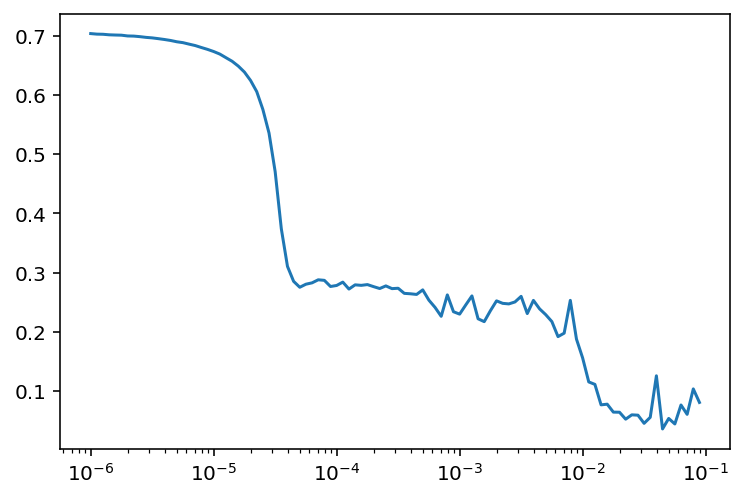

In [71]:
tunerModel, tunerHistory = fitLearningRate(np.array(xTrainArray3), np.array(yTrainArray3[:,1]), np.array(xValArray3), np.array(yValArray3[:,1]), vocab_size, embedding_dim, max_length, 100)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 32)           96032     
_________________________________________________________________
dropout_3 (Dropout)          (None, 120, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 99,185
Trainable params: 99,185
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
59/59 - 2s - loss: 0.2990 - binary_accuracy: 0.9137 - val_loss: 0.1918 - val_binary_accuracy: 0.9524
Epo

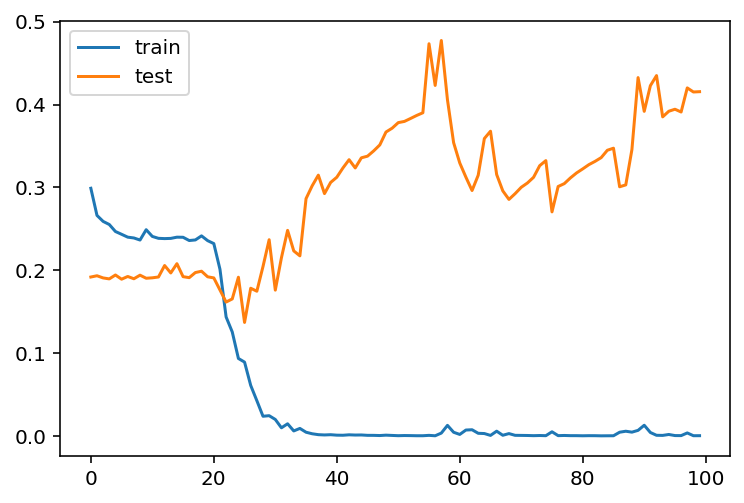

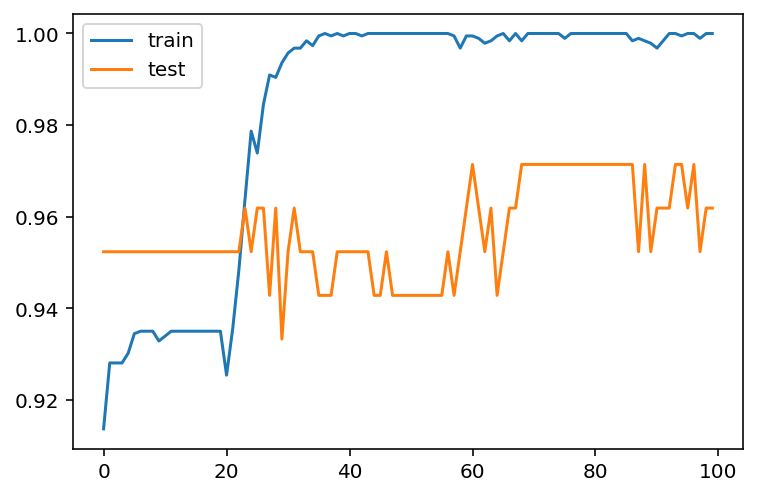

In [72]:
ownModel, ownHistory = startermodelBidirectionalExperimentalBinary(np.array(xTrainArray3), np.array(yTrainArray3[:,1]), np.array(xValArray3), np.array(yValArray3[:,1]), vocab_size, embedding_dim, max_length, 100)

### Predict Model

In [73]:
def predictModel(model, xTest, yTest):

  predictions = model.predict(xTest)
  print(predictions.size)
  print(yTest.size)

  class_labels = np.argmax(predictions, axis=1)
  print("Class Labels:\n")
  print(class_labels)
  test_labels = np.argmax(yTest, axis=1)
  print("Test Labels:\n")
  print(test_labels)
  #class_labels_reshaped = class_labels.reshape(yTest.shape[0],yTest.shape[1])
  class_labels_diff = class_labels - test_labels
  print("Class Labels Diff:\n")
  print(class_labels_diff)
  #label = ["class1", "class2", "class3", "class4", "class5", "class6"]
  
  print(len(xTest))
  print(test_labels.shape)
  print(class_labels.shape)

  #plt.scatter(xTest, class_labels)
  #plt.scatter(xTest, test_labels)

  #plt.title('Test Set Predictions')
  #plt.ylabel('class')

  #plt.legend(loc="upper left")
  #plt.legend(['prediction', 'real test result'], loc='upper right')
  #plt.show()

  return predictions

In [74]:
predictionsOwnModel = predictModel(ownModel, xTestArray3, yTestArray3)

104
208
Class Labels:

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Test Labels:

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1]
Class Labels Diff:

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  0 -1  0 -1  0 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1
 -1 -1 -1  0 -1 -1 -1 -1]
104
(104,)
(104,)


## Bert Model German with simpletransformers

First we need to install the simpletransformers.

In [75]:
# install simpletransformers
!pip install simpletransformers

# check installed version
!pip freeze | grep simpletransformers
# simpletransformers==0.28.2

     |████████████████████████████████| 225kB 7.3MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
     |████████████████████████████████| 122kB 12.6MB/s 
     |████████████████████████████████| 245kB 12.6MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 1.8MB 14.1MB/s 
     |████████████████████████████████| 1.2MB 53.0MB/s 
     |████████████████████████████████| 3.3MB 47.4MB/s 
     |████████████████████████████████| 7.8MB 41.5MB/s 
     |████████████████████████████████| 2.5MB 34.9MB/s 
     |████████████████████████████████| 122kB 61.5MB/s 
     |████████████████████████████████| 245kB 54.8MB/s 
     |████████████████████████████████| 133kB 55.2MB/s 
     |████████████████████████████████| 174kB 50.5MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
     |████████████████████████████████| 112kB 62.8MB/s 
     |████████████████████████████████| 4.2MB 47.4MB/s

simpletransformers==0.61.7


Class 0 refers to impolite mails and class 1 to polite ones, so we renamed them. Making a new dataframe called df is not necessary, just to shorten the names.

In [ ]:
import pandas as pd

class_list = ['Impolite','Polite']

df =azubi_df_mails_and_scored_combined #df[['tweet','pred_class']]

print(df.shape)
df.head()

With the simpletransformers we use a Classification model. In the training arguments some settings of the model can be handed over, e.g. the training_epochs. Afterwards the classification model is created with bert. Furthermore the training arguments are passed.

In [77]:
from simpletransformers.classification import ClassificationModel

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "overwrite_output_dir": True,
             "fp16":False,
             "num_train_epochs": 10}

# Create a ClassificationModel
model = ClassificationModel(
    "bert", "distilbert-base-german-cased",
    #num_labels=1,
    args=train_args
)


Downloading:   0%|          | 0.00/464 [00:00<?, ?B/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/270M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-german-cased were not used when initializing BertForSequenceClassification: ['distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.2.attention.k_lin.weight', 'distilbert.transformer.layer.1.attention.out_lin.weight', 'distilbert.transformer.layer.4.output_layer_norm.weight', 'distilbert.transformer.layer.5.attention.q_lin.weight', 'vocab_transform.bias', 'distilbert.transformer.layer.2.attention.v_lin.weight', 'distilbert.transformer.layer.3.attention.v_lin.bias', 'distilbert.transformer.layer.3.sa_layer_norm.weight', 'distilbert.transformer.layer.5.attention.out_lin.bias', 'distilbert.transformer.layer.4.attention.q_lin.bias', 'distilbert.transformer.layer.1.attention.out_lin.bias', 'distilbert.transformer.layer.1.ffn.lin2.bias', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'distilbert.transformer.layer.2.attention.out_lin.weight', 'distilbert.transformer.layer.4.attention.k_lin.bias

Downloading:   0%|          | 0.00/240k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

The model wants a dataframe instead of a np.array, hence we make a pandas dataframe from our arrays.

In [78]:
# Creating pandas dataframe from numpy array
train_data = pd.DataFrame({'Mails_Combined': xTrainArray, 'a4s_combined_i2b': yTrainArray[:,1]})
val_data = pd.DataFrame({'Mails_Combined': xValArray, 'a4s_combined_i2b': yValArray[:,1]})
test_data = pd.DataFrame({'Mails_Combined': xTestArray, 'a4s_combined_i2b': yTestArray[:,1]})


In [ ]:
test_data.head()

The model is trained with our training data and evaluated with the validation set.

In [119]:
# Train the model
model.train_model(train_df=train_data, eval_df=val_data)


/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1252 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/157 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/157 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/157 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/157 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/157 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/157 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/157 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/157 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/157 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/157 [00:00<?, ?it/s]

(1570, 0.07590062036024219)

Check the metrics to see, how the model performs.

In [120]:
from sklearn.metrics import f1_score, accuracy_score


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = model.eval_model(eval_df=val_data, f1=f1_score, acc=accuracy_score) #eval_df=val_data, f1=f1_score, acc=accuracy_score, verbose=2

result

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1393: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/418 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/53 [00:00<?, ?it/s]

{'acc': 0.9210526315789473,
 'auprc': 0.9642324339682933,
 'auroc': 0.7353797717434081,
 'eval_loss': 0.5817217564244341,
 'f1': 0.9581749049429659,
 'fn': 7,
 'fp': 26,
 'mcc': 0.2906689678051038,
 'tn': 7,
 'tp': 378}

In [121]:
model_outputs

array([[-3.81103897,  4.48985052],
       [ 2.08378887, -2.54024076],
       [-3.80508685,  4.48815918],
       [-3.80635118,  4.48851109],
       [-3.81004858,  4.48963737],
       [-3.81238389,  4.49018049],
       [-3.80837965,  4.48916817],
       [-3.8003087 ,  4.48636627],
       [-3.8026154 ,  4.48725176],
       [-3.80914164,  4.48932171],
       [-3.80440378,  4.48783827],
       [-3.80778027,  4.48899651],
       [-3.8138938 ,  4.49060345],
       [-3.81139994,  4.4899168 ],
       [-3.808146  ,  4.4891324 ],
       [-3.80316114,  4.48740292],
       [-3.79373407,  4.48383045],
       [-3.81287503,  4.49038315],
       [-3.80132341,  4.48672295],
       [-3.79967308,  4.486166  ],
       [-3.78656983,  4.48066235],
       [-3.81300855,  4.49041462],
       [-3.80608034,  4.48837519],
       [-3.81112623,  4.48988152],
       [-3.81154776,  4.4900465 ],
       [-3.80121064,  4.48675108],
       [-3.81164122,  4.48999929],
       [-3.8112402 ,  4.4899559 ],
       [-3.7320838 ,

Check the whole test set, where the model predicted impolite.

In [122]:
class_list = ['Impolite','Polite']

In [123]:
mailsList = test_data['Mails_Combined'].to_list()

In [124]:
prediction, raw_output = model.predict(to_predict=mailsList)

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

In [125]:
prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

All the mails that are classified as impolite by the model.

In [ ]:
print(test_data['Mails_Combined'][83])
print(test_data['a4s_combined_i2b'][83])

print(test_data['Mails_Combined'][92])
print(test_data['a4s_combined_i2b'][92])

print(test_data['Mails_Combined'][129])
print(test_data['a4s_combined_i2b'][129])

print(test_data['Mails_Combined'][149])
print(test_data['a4s_combined_i2b'][149])

print(test_data['Mails_Combined'][174])
print(test_data['a4s_combined_i2b'][174])

print(test_data['Mails_Combined'][210])
print(test_data['a4s_combined_i2b'][210])

print(test_data['Mails_Combined'][264])
print(test_data['a4s_combined_i2b'][264])

print(test_data['Mails_Combined'][283])
print(test_data['a4s_combined_i2b'][283])

print(test_data['Mails_Combined'][303])
print(test_data['a4s_combined_i2b'][303])

print(test_data['Mails_Combined'][308])
print(test_data['a4s_combined_i2b'][308])

print(test_data['Mails_Combined'][329])
print(test_data['a4s_combined_i2b'][329])

print(test_data['Mails_Combined'][338])
print(test_data['a4s_combined_i2b'][338])

print(test_data['Mails_Combined'][342])
print(test_data['a4s_combined_i2b'][342])

print(test_data['Mails_Combined'][344])
print(test_data['a4s_combined_i2b'][344])

print(test_data['Mails_Combined'][357])
print(test_data['a4s_combined_i2b'][357])

print(test_data['Mails_Combined'][391])
print(test_data['a4s_combined_i2b'][391])



Having a look into the data. For some sentences it is at the very least questionable if they are labeled correctly by the scorer. For some sentences model and human scorer have the same opinion, for others they are different and it is not always completely clear to us, why the data has been labelled Polite or Impolite by the scorer. Hence the accuracy of the model is also affected by the initial labelling.

It is though not easy to find a measurable baseline for the scores, as there is a rather large grey zone for polite and impolite answers. The sentences below are an example of this. It is not fully clear, why the mail 118 is considered impolite by the scorer, while mail 391 and 416 are considered polite. There would be arguments for each mail in both directions. In this regard maybe the models can help to develop a standard that follows measurable rules and is not subject to human error.

In [ ]:
test_data['Mails_Combined'][391]

In [128]:
test_data['a4s_combined_i2b'][391]

1.0

In [ ]:
test_data['Mails_Combined'][118]

In [130]:
test_data['a4s_combined_i2b'][118]

0.0

In [ ]:
test_data['Mails_Combined'][416]

In [132]:
test_data['a4s_combined_i2b'][416]

1.0